## Setting up
- Notebook: `Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)` 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/"My Drive"/"Data Colab"/oml-project

/content/drive/My Drive/Data Colab/oml-project


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
from tqdm import tqdm

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
# hyperparameters
BATCH_SIZE = 64

In [ ]:
train_set = torchvision.datasets.CIFAR10('./data', download=True, train=True, transform=transforms.Compose([transforms.ToTensor()]))

Files already downloaded and verified


In [ ]:
test_set = torchvision.datasets.CIFAR10("./data", download=True, train=False, transform=transforms.Compose([transforms.ToTensor()])) 

Files already downloaded and verified


In [ ]:
# sampling for smaller dataset: train
TRAIN_SAMPLES = int(len(train_set) / (10 * 2))
train_class_seen = dict([(i, 0) for i in range(10)])
train_indices = []
for i, (_, l) in enumerate(train_set):
  if train_class_seen[l] >= TRAIN_SAMPLES:
    continue
  train_class_seen[l] += 1
  train_indices.append(i)
train_subset = torch.utils.data.Subset(train_set, train_indices)
len(train_subset)

25000

In [ ]:
# sampling for smaller dataset: test
TEST_SAMPLES = int(len(test_set) / (10 * 3))
test_class_seen = dict([(i, 0) for i in range(10)])
test_indices = []
for i, (_, l) in enumerate(test_set):
  if test_class_seen[l] >= TEST_SAMPLES:
    continue
  test_class_seen[l] += 1
  test_indices.append(i)
test_subset = torch.utils.data.Subset(test_set, test_indices)
# store the test set as a single tensor
test_X, test_Y = [], []
for s, l in test_subset:
  test_X.append(s)
  test_Y.append(l)
test_X = torch.stack(test_X).float()
test_Y = torch.tensor(test_Y).long()
test_X, test_Y = test_X.to(device), test_Y.to(device)
test_X.shape, test_Y.shape

(torch.Size([3330, 3, 32, 32]), torch.Size([3330]))

In [ ]:
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

## Analysis

In [ ]:
sample_image, sample_label = train_set[100]

In [ ]:
sample_image.shape

torch.Size([3, 32, 32])

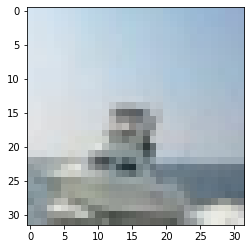

In [ ]:
plt.imshow(np.transpose(sample_image.numpy(), (1, 2, 0)))
plt.show()

In [ ]:
len(train_set), len(test_set)

(50000, 10000)

In [ ]:
sample_batch = next(iter(train_loader))
sample_batch = sample_batch[0].to(device), sample_batch[1].to(device)
sample_batch[0].shape, sample_batch[1].shape

(torch.Size([64, 3, 32, 32]), torch.Size([64]))

## Model

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3),
      nn.MaxPool2d(kernel_size=2),
      nn.ReLU(),
    )
    self.lin = nn.Sequential(
        nn.Linear(in_features=32*15*15, out_features=600),
        nn.ReLU(),
        nn.Linear(in_features=600, out_features=120),
        nn.ReLU(),
        nn.Linear(in_features=120, out_features=10)
    )
    self.softmax = nn.LogSoftmax(dim=1)
  def forward(self, x):
    out = self.conv(x)
    out = out.view(out.size(0), -1)
    out = self.lin(out)
    out = self.softmax(out)
    return out
model = CNN()
model.to(device)

CNN(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (lin): Sequential(
    (0): Linear(in_features=7200, out_features=600, bias=True)
    (1): ReLU()
    (2): Linear(in_features=600, out_features=120, bias=True)
    (3): ReLU()
    (4): Linear(in_features=120, out_features=10, bias=True)
  )
  (softmax): LogSoftmax(dim=1)
)

In [ ]:
# hyperparameters
NUM_EPOCHS = 100

In [ ]:
error = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)

## Training

In [ ]:
DISPLAY_INTERVAL = 1
train_loss, test_loss = [], [] # denotes the mean loss over all samples
train_acc, test_acc = [], []
for epoch in range(1, NUM_EPOCHS + 1):
  total_loss = 0
  correct, total = 0, 0
  for images, labels in tqdm(train_loader):
    # forward + backward + step
    optimizer.zero_grad()
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    loss = error(outputs, labels)
    total_loss += loss.item() * len(outputs)
    loss.backward()
    optimizer.step()
    # accuracy calculation
    correct += (torch.argmax(outputs, dim=1) == labels).sum()
    total += len(labels)
  train_loss.append(total_loss / total)
  train_acc.append(correct / total)
  # testing loss
  with torch.no_grad():
    predicted = model(test_X)
    loss = error(predicted, test_Y)
    test_loss.append(loss.item())
    test_acc.append((torch.argmax(predicted, dim=1) == test_Y).sum() / len(test_Y))

  if epoch % DISPLAY_INTERVAL == 0:
      print(f'Performace at epoch {epoch}')
      print(f'Train Loss: {train_loss[-1]:.5f} ; Train Acc: {train_acc[-1]:.5f}')
      print(f'Test Loss: {test_loss[-1]:.5f} ; Test Acc: {test_acc[-1]:.5f}')
      print('==============')

100%|██████████| 391/391 [00:06<00:00, 61.75it/s]


Performace at epoch 1
Train Loss: 1.69536 ; Train Acc: 0.38044
Test Loss: 1.45310 ; Test Acc: 0.48649


100%|██████████| 391/391 [00:05<00:00, 66.56it/s]


Performace at epoch 2
Train Loss: 1.30598 ; Train Acc: 0.53216
Test Loss: 1.28693 ; Test Acc: 0.54264


100%|██████████| 391/391 [00:05<00:00, 66.47it/s]


Performace at epoch 3
Train Loss: 1.14201 ; Train Acc: 0.59340
Test Loss: 1.18738 ; Test Acc: 0.57658


100%|██████████| 391/391 [00:05<00:00, 66.32it/s]


Performace at epoch 4
Train Loss: 1.00632 ; Train Acc: 0.64256
Test Loss: 1.17099 ; Test Acc: 0.59670


100%|██████████| 391/391 [00:05<00:00, 65.80it/s]


Performace at epoch 5
Train Loss: 0.87544 ; Train Acc: 0.69004
Test Loss: 1.11712 ; Test Acc: 0.60631


100%|██████████| 391/391 [00:05<00:00, 65.53it/s]


Performace at epoch 6
Train Loss: 0.75090 ; Train Acc: 0.73508
Test Loss: 1.11362 ; Test Acc: 0.61742


100%|██████████| 391/391 [00:05<00:00, 66.65it/s]


Performace at epoch 7
Train Loss: 0.61998 ; Train Acc: 0.78308
Test Loss: 1.18914 ; Test Acc: 0.61261


100%|██████████| 391/391 [00:05<00:00, 65.63it/s]


Performace at epoch 8
Train Loss: 0.49407 ; Train Acc: 0.83024
Test Loss: 1.15986 ; Test Acc: 0.62012


100%|██████████| 391/391 [00:05<00:00, 65.21it/s]


Performace at epoch 9
Train Loss: 0.37062 ; Train Acc: 0.87396
Test Loss: 1.31267 ; Test Acc: 0.62132


100%|██████████| 391/391 [00:05<00:00, 65.95it/s]


Performace at epoch 10
Train Loss: 0.26314 ; Train Acc: 0.91572
Test Loss: 1.53476 ; Test Acc: 0.61351


100%|██████████| 391/391 [00:05<00:00, 65.49it/s]


Performace at epoch 11
Train Loss: 0.18918 ; Train Acc: 0.93828
Test Loss: 1.66189 ; Test Acc: 0.60541


100%|██████████| 391/391 [00:05<00:00, 66.53it/s]


Performace at epoch 12
Train Loss: 0.12627 ; Train Acc: 0.96248
Test Loss: 1.79661 ; Test Acc: 0.62162


100%|██████████| 391/391 [00:05<00:00, 66.48it/s]


Performace at epoch 13
Train Loss: 0.08564 ; Train Acc: 0.97496
Test Loss: 1.97542 ; Test Acc: 0.61652


100%|██████████| 391/391 [00:05<00:00, 65.92it/s]


Performace at epoch 14
Train Loss: 0.07411 ; Train Acc: 0.97880
Test Loss: 2.20137 ; Test Acc: 0.59910


100%|██████████| 391/391 [00:05<00:00, 66.60it/s]


Performace at epoch 15
Train Loss: 0.07380 ; Train Acc: 0.97736
Test Loss: 2.15338 ; Test Acc: 0.61081


100%|██████████| 391/391 [00:05<00:00, 65.64it/s]


Performace at epoch 16
Train Loss: 0.10071 ; Train Acc: 0.96744
Test Loss: 2.45552 ; Test Acc: 0.59820


100%|██████████| 391/391 [00:05<00:00, 65.81it/s]


Performace at epoch 17
Train Loss: 0.07194 ; Train Acc: 0.97684
Test Loss: 2.29143 ; Test Acc: 0.61742


100%|██████████| 391/391 [00:05<00:00, 65.91it/s]


Performace at epoch 18
Train Loss: 0.05242 ; Train Acc: 0.98388
Test Loss: 2.43773 ; Test Acc: 0.61952


100%|██████████| 391/391 [00:05<00:00, 66.04it/s]


Performace at epoch 19
Train Loss: 0.05593 ; Train Acc: 0.98340
Test Loss: 2.52774 ; Test Acc: 0.61592


100%|██████████| 391/391 [00:05<00:00, 65.91it/s]


Performace at epoch 20
Train Loss: 0.05992 ; Train Acc: 0.97980
Test Loss: 2.61326 ; Test Acc: 0.61562


100%|██████████| 391/391 [00:06<00:00, 64.01it/s]


Performace at epoch 21
Train Loss: 0.04542 ; Train Acc: 0.98556
Test Loss: 2.74186 ; Test Acc: 0.61682


100%|██████████| 391/391 [00:05<00:00, 65.81it/s]


Performace at epoch 22
Train Loss: 0.06303 ; Train Acc: 0.97996
Test Loss: 2.88461 ; Test Acc: 0.59760


100%|██████████| 391/391 [00:05<00:00, 65.99it/s]


Performace at epoch 23
Train Loss: 0.05222 ; Train Acc: 0.98316
Test Loss: 2.88064 ; Test Acc: 0.60090


100%|██████████| 391/391 [00:05<00:00, 66.06it/s]


Performace at epoch 24
Train Loss: 0.05853 ; Train Acc: 0.98048
Test Loss: 2.73763 ; Test Acc: 0.61832


100%|██████████| 391/391 [00:05<00:00, 65.52it/s]


Performace at epoch 25
Train Loss: 0.03767 ; Train Acc: 0.98860
Test Loss: 2.91085 ; Test Acc: 0.61862


100%|██████████| 391/391 [00:05<00:00, 65.32it/s]


Performace at epoch 26
Train Loss: 0.03373 ; Train Acc: 0.98932
Test Loss: 3.14570 ; Test Acc: 0.60781


100%|██████████| 391/391 [00:05<00:00, 65.55it/s]


Performace at epoch 27
Train Loss: 0.03706 ; Train Acc: 0.98828
Test Loss: 2.97015 ; Test Acc: 0.60210


100%|██████████| 391/391 [00:05<00:00, 65.50it/s]


Performace at epoch 28
Train Loss: 0.05257 ; Train Acc: 0.98308
Test Loss: 2.91839 ; Test Acc: 0.60270


100%|██████████| 391/391 [00:05<00:00, 65.92it/s]


Performace at epoch 29
Train Loss: 0.04688 ; Train Acc: 0.98396
Test Loss: 3.21887 ; Test Acc: 0.60751


100%|██████████| 391/391 [00:05<00:00, 65.72it/s]


Performace at epoch 30
Train Loss: 0.03229 ; Train Acc: 0.98948
Test Loss: 3.22238 ; Test Acc: 0.61111


100%|██████████| 391/391 [00:05<00:00, 65.83it/s]


Performace at epoch 31
Train Loss: 0.03401 ; Train Acc: 0.98852
Test Loss: 3.42116 ; Test Acc: 0.59820


100%|██████████| 391/391 [00:05<00:00, 65.87it/s]


Performace at epoch 32
Train Loss: 0.05695 ; Train Acc: 0.98072
Test Loss: 3.23455 ; Test Acc: 0.61051


100%|██████████| 391/391 [00:06<00:00, 64.99it/s]


Performace at epoch 33
Train Loss: 0.02161 ; Train Acc: 0.99336
Test Loss: 3.42290 ; Test Acc: 0.61652


100%|██████████| 391/391 [00:06<00:00, 64.93it/s]


Performace at epoch 34
Train Loss: 0.01240 ; Train Acc: 0.99628
Test Loss: 3.53576 ; Test Acc: 0.60060


100%|██████████| 391/391 [00:05<00:00, 65.62it/s]


Performace at epoch 35
Train Loss: 0.05858 ; Train Acc: 0.97972
Test Loss: 3.35640 ; Test Acc: 0.60631


100%|██████████| 391/391 [00:06<00:00, 65.12it/s]


Performace at epoch 36
Train Loss: 0.03993 ; Train Acc: 0.98716
Test Loss: 3.41505 ; Test Acc: 0.60541


100%|██████████| 391/391 [00:05<00:00, 65.66it/s]


Performace at epoch 37
Train Loss: 0.03206 ; Train Acc: 0.98916
Test Loss: 3.53095 ; Test Acc: 0.61321


100%|██████████| 391/391 [00:06<00:00, 64.30it/s]


Performace at epoch 38
Train Loss: 0.01801 ; Train Acc: 0.99396
Test Loss: 3.82860 ; Test Acc: 0.59069


100%|██████████| 391/391 [00:06<00:00, 64.99it/s]


Performace at epoch 39
Train Loss: 0.04763 ; Train Acc: 0.98432
Test Loss: 3.72148 ; Test Acc: 0.59700


100%|██████████| 391/391 [00:06<00:00, 64.82it/s]


Performace at epoch 40
Train Loss: 0.03224 ; Train Acc: 0.98976
Test Loss: 3.66826 ; Test Acc: 0.60090


100%|██████████| 391/391 [00:06<00:00, 64.37it/s]


Performace at epoch 41
Train Loss: 0.03468 ; Train Acc: 0.98928
Test Loss: 4.31069 ; Test Acc: 0.59339


100%|██████████| 391/391 [00:06<00:00, 64.23it/s]


Performace at epoch 42
Train Loss: 0.02478 ; Train Acc: 0.99208
Test Loss: 3.88943 ; Test Acc: 0.60781


100%|██████████| 391/391 [00:06<00:00, 64.23it/s]


Performace at epoch 43
Train Loss: 0.04478 ; Train Acc: 0.98568
Test Loss: 3.55135 ; Test Acc: 0.61021


100%|██████████| 391/391 [00:05<00:00, 65.50it/s]


Performace at epoch 44
Train Loss: 0.02838 ; Train Acc: 0.99096
Test Loss: 3.64151 ; Test Acc: 0.60571


100%|██████████| 391/391 [00:06<00:00, 65.05it/s]


Performace at epoch 45
Train Loss: 0.01344 ; Train Acc: 0.99580
Test Loss: 3.88280 ; Test Acc: 0.61532


100%|██████████| 391/391 [00:05<00:00, 65.50it/s]


Performace at epoch 46
Train Loss: 0.01724 ; Train Acc: 0.99392
Test Loss: 3.84648 ; Test Acc: 0.61351


100%|██████████| 391/391 [00:05<00:00, 65.57it/s]


Performace at epoch 47
Train Loss: 0.04307 ; Train Acc: 0.98624
Test Loss: 3.61815 ; Test Acc: 0.59550


100%|██████████| 391/391 [00:06<00:00, 64.35it/s]


Performace at epoch 48
Train Loss: 0.03288 ; Train Acc: 0.98888
Test Loss: 3.91582 ; Test Acc: 0.60480


100%|██████████| 391/391 [00:06<00:00, 63.46it/s]


Performace at epoch 49
Train Loss: 0.01291 ; Train Acc: 0.99584
Test Loss: 3.85877 ; Test Acc: 0.60420


100%|██████████| 391/391 [00:06<00:00, 63.85it/s]


Performace at epoch 50
Train Loss: 0.03471 ; Train Acc: 0.98912
Test Loss: 3.96614 ; Test Acc: 0.60240


100%|██████████| 391/391 [00:06<00:00, 63.23it/s]


Performace at epoch 51
Train Loss: 0.03568 ; Train Acc: 0.98860
Test Loss: 4.01937 ; Test Acc: 0.59970


100%|██████████| 391/391 [00:06<00:00, 64.35it/s]


Performace at epoch 52
Train Loss: 0.02396 ; Train Acc: 0.99176
Test Loss: 3.95417 ; Test Acc: 0.61381


100%|██████████| 391/391 [00:06<00:00, 64.36it/s]


Performace at epoch 53
Train Loss: 0.02766 ; Train Acc: 0.99232
Test Loss: 3.91191 ; Test Acc: 0.59790


100%|██████████| 391/391 [00:06<00:00, 63.93it/s]


Performace at epoch 54
Train Loss: 0.02387 ; Train Acc: 0.99248
Test Loss: 4.05187 ; Test Acc: 0.60991


100%|██████████| 391/391 [00:06<00:00, 63.57it/s]


Performace at epoch 55
Train Loss: 0.02149 ; Train Acc: 0.99320
Test Loss: 4.36537 ; Test Acc: 0.60450


100%|██████████| 391/391 [00:06<00:00, 63.17it/s]


Performace at epoch 56
Train Loss: 0.01408 ; Train Acc: 0.99560
Test Loss: 4.13016 ; Test Acc: 0.59580


100%|██████████| 391/391 [00:06<00:00, 62.84it/s]


Performace at epoch 57
Train Loss: 0.04490 ; Train Acc: 0.98644
Test Loss: 3.91859 ; Test Acc: 0.60120


100%|██████████| 391/391 [00:06<00:00, 63.19it/s]


Performace at epoch 58
Train Loss: 0.02414 ; Train Acc: 0.99208
Test Loss: 4.16188 ; Test Acc: 0.60120


100%|██████████| 391/391 [00:06<00:00, 64.72it/s]


Performace at epoch 59
Train Loss: 0.02404 ; Train Acc: 0.99232
Test Loss: 4.21308 ; Test Acc: 0.60300


100%|██████████| 391/391 [00:06<00:00, 63.19it/s]


Performace at epoch 60
Train Loss: 0.02002 ; Train Acc: 0.99348
Test Loss: 4.29128 ; Test Acc: 0.59129


100%|██████████| 391/391 [00:06<00:00, 63.53it/s]


Performace at epoch 61
Train Loss: 0.02053 ; Train Acc: 0.99404
Test Loss: 4.53901 ; Test Acc: 0.60360


100%|██████████| 391/391 [00:06<00:00, 64.43it/s]


Performace at epoch 62
Train Loss: 0.03061 ; Train Acc: 0.98996
Test Loss: 4.33793 ; Test Acc: 0.60360


100%|██████████| 391/391 [00:06<00:00, 64.40it/s]


Performace at epoch 63
Train Loss: 0.01880 ; Train Acc: 0.99440
Test Loss: 4.25411 ; Test Acc: 0.60150


100%|██████████| 391/391 [00:06<00:00, 64.60it/s]


Performace at epoch 64
Train Loss: 0.00647 ; Train Acc: 0.99836
Test Loss: 4.38523 ; Test Acc: 0.61351


100%|██████████| 391/391 [00:06<00:00, 64.15it/s]


Performace at epoch 65
Train Loss: 0.01257 ; Train Acc: 0.99612
Test Loss: 4.47371 ; Test Acc: 0.60060


100%|██████████| 391/391 [00:06<00:00, 64.43it/s]


Performace at epoch 66
Train Loss: 0.04217 ; Train Acc: 0.98716
Test Loss: 4.67773 ; Test Acc: 0.59069


100%|██████████| 391/391 [00:06<00:00, 64.46it/s]


Performace at epoch 67
Train Loss: 0.02511 ; Train Acc: 0.99188
Test Loss: 4.17902 ; Test Acc: 0.60270


100%|██████████| 391/391 [00:06<00:00, 64.65it/s]


Performace at epoch 68
Train Loss: 0.02196 ; Train Acc: 0.99368
Test Loss: 4.54166 ; Test Acc: 0.60120


100%|██████████| 391/391 [00:06<00:00, 63.73it/s]


Performace at epoch 69
Train Loss: 0.03667 ; Train Acc: 0.98944
Test Loss: 4.36695 ; Test Acc: 0.60631


100%|██████████| 391/391 [00:06<00:00, 64.14it/s]


Performace at epoch 70
Train Loss: 0.01217 ; Train Acc: 0.99648
Test Loss: 4.52945 ; Test Acc: 0.60781


100%|██████████| 391/391 [00:06<00:00, 64.41it/s]


Performace at epoch 71
Train Loss: 0.02253 ; Train Acc: 0.99276
Test Loss: 4.50304 ; Test Acc: 0.59550


100%|██████████| 391/391 [00:06<00:00, 64.45it/s]


Performace at epoch 72
Train Loss: 0.01846 ; Train Acc: 0.99436
Test Loss: 4.44760 ; Test Acc: 0.59429


100%|██████████| 391/391 [00:06<00:00, 64.61it/s]


Performace at epoch 73
Train Loss: 0.03039 ; Train Acc: 0.99180
Test Loss: 4.33189 ; Test Acc: 0.61021


100%|██████████| 391/391 [00:06<00:00, 65.14it/s]


Performace at epoch 74
Train Loss: 0.01695 ; Train Acc: 0.99500
Test Loss: 4.43464 ; Test Acc: 0.59790


100%|██████████| 391/391 [00:06<00:00, 64.76it/s]


Performace at epoch 75
Train Loss: 0.01376 ; Train Acc: 0.99548
Test Loss: 4.34540 ; Test Acc: 0.61171


100%|██████████| 391/391 [00:05<00:00, 65.63it/s]


Performace at epoch 76
Train Loss: 0.02471 ; Train Acc: 0.99260
Test Loss: 4.41356 ; Test Acc: 0.59910


100%|██████████| 391/391 [00:06<00:00, 64.91it/s]


Performace at epoch 77
Train Loss: 0.02826 ; Train Acc: 0.99212
Test Loss: 4.39553 ; Test Acc: 0.59459


100%|██████████| 391/391 [00:06<00:00, 64.97it/s]


Performace at epoch 78
Train Loss: 0.01480 ; Train Acc: 0.99508
Test Loss: 4.59900 ; Test Acc: 0.60781


100%|██████████| 391/391 [00:05<00:00, 65.32it/s]


Performace at epoch 79
Train Loss: 0.00926 ; Train Acc: 0.99700
Test Loss: 4.52008 ; Test Acc: 0.59249


100%|██████████| 391/391 [00:06<00:00, 65.02it/s]


Performace at epoch 80
Train Loss: 0.00736 ; Train Acc: 0.99816
Test Loss: 4.82333 ; Test Acc: 0.59489


100%|██████████| 391/391 [00:06<00:00, 65.12it/s]


Performace at epoch 81
Train Loss: 0.03043 ; Train Acc: 0.99128
Test Loss: 4.83686 ; Test Acc: 0.57808


100%|██████████| 391/391 [00:06<00:00, 64.63it/s]


Performace at epoch 82
Train Loss: 0.03813 ; Train Acc: 0.98900
Test Loss: 4.44696 ; Test Acc: 0.59580


100%|██████████| 391/391 [00:06<00:00, 64.48it/s]


Performace at epoch 83
Train Loss: 0.01169 ; Train Acc: 0.99608
Test Loss: 4.84531 ; Test Acc: 0.60450


100%|██████████| 391/391 [00:05<00:00, 65.65it/s]


Performace at epoch 84
Train Loss: 0.01299 ; Train Acc: 0.99596
Test Loss: 4.56050 ; Test Acc: 0.59369


100%|██████████| 391/391 [00:06<00:00, 64.07it/s]


Performace at epoch 85
Train Loss: 0.02805 ; Train Acc: 0.99132
Test Loss: 4.54188 ; Test Acc: 0.59940


100%|██████████| 391/391 [00:05<00:00, 65.32it/s]


Performace at epoch 86
Train Loss: 0.00872 ; Train Acc: 0.99744
Test Loss: 4.39537 ; Test Acc: 0.60360


100%|██████████| 391/391 [00:05<00:00, 65.91it/s]


Performace at epoch 87
Train Loss: 0.01098 ; Train Acc: 0.99632
Test Loss: 4.30877 ; Test Acc: 0.60721


100%|██████████| 391/391 [00:05<00:00, 65.97it/s]


Performace at epoch 88
Train Loss: 0.02072 ; Train Acc: 0.99376
Test Loss: 4.63996 ; Test Acc: 0.59640


100%|██████████| 391/391 [00:05<00:00, 65.45it/s]


Performace at epoch 89
Train Loss: 0.02616 ; Train Acc: 0.99220
Test Loss: 4.67949 ; Test Acc: 0.60541


100%|██████████| 391/391 [00:05<00:00, 65.35it/s]


Performace at epoch 90
Train Loss: 0.02960 ; Train Acc: 0.99108
Test Loss: 4.61685 ; Test Acc: 0.60060


100%|██████████| 391/391 [00:06<00:00, 64.58it/s]


Performace at epoch 91
Train Loss: 0.01392 ; Train Acc: 0.99580
Test Loss: 4.47104 ; Test Acc: 0.62102


100%|██████████| 391/391 [00:06<00:00, 64.40it/s]


Performace at epoch 92
Train Loss: 0.01342 ; Train Acc: 0.99596
Test Loss: 4.90333 ; Test Acc: 0.59700


100%|██████████| 391/391 [00:06<00:00, 64.89it/s]


Performace at epoch 93
Train Loss: 0.02165 ; Train Acc: 0.99356
Test Loss: 4.79511 ; Test Acc: 0.59369


100%|██████████| 391/391 [00:06<00:00, 64.77it/s]


Performace at epoch 94
Train Loss: 0.02315 ; Train Acc: 0.99300
Test Loss: 4.70368 ; Test Acc: 0.60480


100%|██████████| 391/391 [00:06<00:00, 64.83it/s]


Performace at epoch 95
Train Loss: 0.01391 ; Train Acc: 0.99560
Test Loss: 4.95696 ; Test Acc: 0.59099


100%|██████████| 391/391 [00:05<00:00, 65.53it/s]


Performace at epoch 96
Train Loss: 0.02296 ; Train Acc: 0.99368
Test Loss: 5.05561 ; Test Acc: 0.58739


100%|██████████| 391/391 [00:06<00:00, 64.81it/s]


Performace at epoch 97
Train Loss: 0.01806 ; Train Acc: 0.99488
Test Loss: 4.74428 ; Test Acc: 0.57417


100%|██████████| 391/391 [00:06<00:00, 65.03it/s]


Performace at epoch 98
Train Loss: 0.01515 ; Train Acc: 0.99484
Test Loss: 4.97283 ; Test Acc: 0.60030


100%|██████████| 391/391 [00:06<00:00, 64.77it/s]


Performace at epoch 99
Train Loss: 0.01614 ; Train Acc: 0.99608
Test Loss: 4.72360 ; Test Acc: 0.60300


100%|██████████| 391/391 [00:06<00:00, 65.07it/s]

Performace at epoch 100
Train Loss: 0.00851 ; Train Acc: 0.99740
Test Loss: 4.54911 ; Test Acc: 0.60030


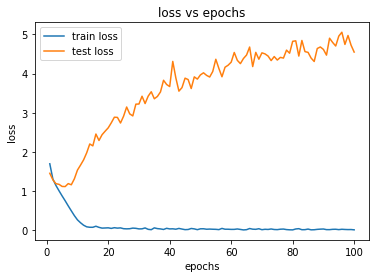

In [ ]:
# plot loss
plt.plot(range(1, len(train_loss) + 1), train_loss, label='train loss')
plt.plot(range(1, len(test_loss) + 1), test_loss, label='test loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss vs epochs')
plt.legend()
plt.show()

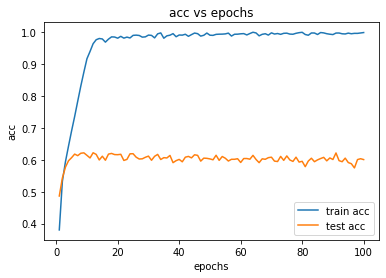

In [ ]:
# plot acc
plt.plot(range(1, NUM_EPOCHS + 1), train_acc, label='train acc')
plt.plot(range(1, NUM_EPOCHS + 1), test_acc, label='test acc')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.title('acc vs epochs')
plt.legend()
plt.show()

## Hyperparameter tuning
- For a set of hyperparameters, various trials with different models are trained based on randomly-sampled or exhaustive hyperparameters upto a certain number of epochs (dependent on lr). Finally the best set of hyperparameters are chosen which correspond to the minimum testing loss after training.

In [ ]:
import decimal

In [ ]:
HYPERPARAMS = {
    'lr': [0.01, 0.005, 0.001, 0.0001],
    'beta1': [0.5, 0.7, 0.9],
    'beta2': [0.9, 0.95, 0.999],
    'eps': [1e-7, 1e-8, 1e-9],
    'weight_decay': [1e-5, 1e-6]
}
TRIALS = 10

def get_epochs(lr):
    '''
    returns number of epochs for a given learning rate while tuning
    '''
    d = decimal.Decimal(str(lr))
    pow = d.as_tuple().exponent
    if pow >= -1:
        return 10
    elif pow >= -2:
        return 15
    elif pow >= -3:
        return 20
    else:
        return 25

In [ ]:
best_params, min_loss = None, np.inf
for t in range(TRIALS):
    print(f'\n> Starting trial {t+1}')
    ## choose a set of hyperparameters
    chosen = {}
    for h in HYPERPARAMS:
        chosen[h] = np.random.choice(HYPERPARAMS[h])
    print(f'Chosen hyperparams: {chosen}')
    print()
    ## model, loss & optimizer
    model = CNN()
    model.to(device)
    error = nn.NLLLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=chosen['lr'], betas=(chosen['beta1'], chosen['beta2']), eps=chosen['eps'], weight_decay=chosen['weight_decay'])
    ## training
    EPOCHS_TEST = get_epochs(chosen['lr'])
    for epoch in range(1, EPOCHS_TEST + 1):
        total_loss = 0; total = 0
        for images, labels in tqdm(train_loader):
            # forward + backward + step
            optimizer.zero_grad()
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = error(outputs, labels)
            total_loss += loss.item() * len(outputs)
            loss.backward() 
            optimizer.step() 
            total += len(labels)
        total_loss /= total
        print(f'Training loss at epoch {epoch}: {total_loss:.5f}')
    ## calculate testing loss
    with torch.no_grad():
        predicted = model(test_X)
        testing_loss = error(predicted, test_Y).item()
    print(f'* Testing loss: {testing_loss:.5f}')
    ## check final total loss
    if testing_loss < min_loss:
        min_loss = testing_loss
        best_params = chosen
        print()
        print(f'* Best params updated!: {best_params}')
    print('==============')


> Starting trial 1
Chosen hyperparams: {'lr': 0.01, 'beta1': 0.5, 'beta2': 0.95, 'eps': 1e-07, 'weight_decay': 1e-06}



100%|██████████| 391/391 [00:06<00:00, 62.46it/s]


Training loss at epoch 1: 2.32487


100%|██████████| 391/391 [00:06<00:00, 63.70it/s]


Training loss at epoch 2: 1.61819


100%|██████████| 391/391 [00:06<00:00, 63.53it/s]


Training loss at epoch 3: 1.42156


100%|██████████| 391/391 [00:06<00:00, 64.86it/s]


Training loss at epoch 4: 1.31607


100%|██████████| 391/391 [00:06<00:00, 64.03it/s]


Training loss at epoch 5: 1.24042


100%|██████████| 391/391 [00:06<00:00, 64.17it/s]


Training loss at epoch 6: 1.18062


100%|██████████| 391/391 [00:05<00:00, 65.26it/s]


Training loss at epoch 7: 1.12673


100%|██████████| 391/391 [00:06<00:00, 64.39it/s]


Training loss at epoch 8: 1.08384


100%|██████████| 391/391 [00:06<00:00, 64.14it/s]


Training loss at epoch 9: 1.03026


100%|██████████| 391/391 [00:05<00:00, 65.27it/s]


Training loss at epoch 10: 0.99136


100%|██████████| 391/391 [00:06<00:00, 63.27it/s]


Training loss at epoch 11: 0.95452


100%|██████████| 391/391 [00:06<00:00, 63.63it/s]


Training loss at epoch 12: 0.92470


100%|██████████| 391/391 [00:06<00:00, 64.19it/s]


Training loss at epoch 13: 0.90067


100%|██████████| 391/391 [00:06<00:00, 64.11it/s]


Training loss at epoch 14: 0.87471


100%|██████████| 391/391 [00:06<00:00, 64.02it/s]


Training loss at epoch 15: 0.85050
* Testing loss: 1.80210

* Best params updated!: {'lr': 0.01, 'beta1': 0.5, 'beta2': 0.95, 'eps': 1e-07, 'weight_decay': 1e-06}

> Starting trial 2
Chosen hyperparams: {'lr': 0.01, 'beta1': 0.7, 'beta2': 0.999, 'eps': 1e-07, 'weight_decay': 1e-06}



100%|██████████| 391/391 [00:06<00:00, 63.49it/s]


Training loss at epoch 1: 1.95482


100%|██████████| 391/391 [00:06<00:00, 62.99it/s]


Training loss at epoch 2: 1.57562


100%|██████████| 391/391 [00:06<00:00, 64.03it/s]


Training loss at epoch 3: 1.42140


100%|██████████| 391/391 [00:06<00:00, 63.93it/s]


Training loss at epoch 4: 1.28894


100%|██████████| 391/391 [00:06<00:00, 63.88it/s]


Training loss at epoch 5: 1.15913


100%|██████████| 391/391 [00:06<00:00, 62.79it/s]


Training loss at epoch 6: 1.01674


100%|██████████| 391/391 [00:06<00:00, 64.00it/s]


Training loss at epoch 7: 0.93710


100%|██████████| 391/391 [00:06<00:00, 62.99it/s]


Training loss at epoch 8: 0.78334


100%|██████████| 391/391 [00:06<00:00, 63.45it/s]


Training loss at epoch 9: 0.67521


100%|██████████| 391/391 [00:06<00:00, 64.21it/s]


Training loss at epoch 10: 0.57749


100%|██████████| 391/391 [00:06<00:00, 63.71it/s]


Training loss at epoch 11: 0.53710


100%|██████████| 391/391 [00:06<00:00, 62.38it/s]


Training loss at epoch 12: 0.49327


100%|██████████| 391/391 [00:06<00:00, 64.59it/s]


Training loss at epoch 13: 0.43141


100%|██████████| 391/391 [00:06<00:00, 63.98it/s]


Training loss at epoch 14: 0.40664


100%|██████████| 391/391 [00:06<00:00, 63.90it/s]


Training loss at epoch 15: 0.38250
* Testing loss: 3.06447

> Starting trial 3
Chosen hyperparams: {'lr': 0.005, 'beta1': 0.5, 'beta2': 0.95, 'eps': 1e-08, 'weight_decay': 1e-06}



100%|██████████| 391/391 [00:06<00:00, 63.73it/s]


Training loss at epoch 1: 1.70010


100%|██████████| 391/391 [00:06<00:00, 62.82it/s]


Training loss at epoch 2: 1.32153


100%|██████████| 391/391 [00:06<00:00, 63.13it/s]


Training loss at epoch 3: 1.13033


100%|██████████| 391/391 [00:06<00:00, 63.70it/s]


Training loss at epoch 4: 0.96956


100%|██████████| 391/391 [00:06<00:00, 64.26it/s]


Training loss at epoch 5: 0.82284


100%|██████████| 391/391 [00:06<00:00, 63.07it/s]


Training loss at epoch 6: 0.69280


100%|██████████| 391/391 [00:06<00:00, 63.61it/s]


Training loss at epoch 7: 0.58728


100%|██████████| 391/391 [00:06<00:00, 63.51it/s]


Training loss at epoch 8: 0.48559


100%|██████████| 391/391 [00:06<00:00, 64.09it/s]


Training loss at epoch 9: 0.42272


100%|██████████| 391/391 [00:06<00:00, 63.51it/s]


Training loss at epoch 10: 0.37653


100%|██████████| 391/391 [00:06<00:00, 64.31it/s]


Training loss at epoch 11: 0.32707


100%|██████████| 391/391 [00:06<00:00, 63.63it/s]


Training loss at epoch 12: 0.31000


100%|██████████| 391/391 [00:06<00:00, 63.34it/s]


Training loss at epoch 13: 0.27995


100%|██████████| 391/391 [00:06<00:00, 63.99it/s]


Training loss at epoch 14: 0.26257


100%|██████████| 391/391 [00:06<00:00, 64.01it/s]


Training loss at epoch 15: 0.25741


100%|██████████| 391/391 [00:06<00:00, 64.05it/s]


Training loss at epoch 16: 0.24237


100%|██████████| 391/391 [00:06<00:00, 65.09it/s]


Training loss at epoch 17: 0.24782


100%|██████████| 391/391 [00:06<00:00, 64.10it/s]


Training loss at epoch 18: 0.22842


100%|██████████| 391/391 [00:06<00:00, 64.39it/s]


Training loss at epoch 19: 0.22098


100%|██████████| 391/391 [00:06<00:00, 64.12it/s]


Training loss at epoch 20: 0.20902
* Testing loss: 4.52591

> Starting trial 4
Chosen hyperparams: {'lr': 0.01, 'beta1': 0.7, 'beta2': 0.95, 'eps': 1e-09, 'weight_decay': 1e-05}



100%|██████████| 391/391 [00:06<00:00, 63.66it/s]


Training loss at epoch 1: 1.79393


100%|██████████| 391/391 [00:06<00:00, 63.59it/s]


Training loss at epoch 2: 1.45692


100%|██████████| 391/391 [00:06<00:00, 63.19it/s]


Training loss at epoch 3: 1.33079


100%|██████████| 391/391 [00:06<00:00, 63.68it/s]


Training loss at epoch 4: 1.22089


100%|██████████| 391/391 [00:06<00:00, 64.01it/s]


Training loss at epoch 5: 1.12059


100%|██████████| 391/391 [00:06<00:00, 64.20it/s]


Training loss at epoch 6: 1.03714


100%|██████████| 391/391 [00:06<00:00, 64.04it/s]


Training loss at epoch 7: 0.95287


100%|██████████| 391/391 [00:06<00:00, 63.87it/s]


Training loss at epoch 8: 0.87130


100%|██████████| 391/391 [00:06<00:00, 63.08it/s]


Training loss at epoch 9: 0.81030


100%|██████████| 391/391 [00:06<00:00, 63.35it/s]


Training loss at epoch 10: 0.74370


100%|██████████| 391/391 [00:06<00:00, 63.46it/s]


Training loss at epoch 11: 0.69811


100%|██████████| 391/391 [00:06<00:00, 64.24it/s]


Training loss at epoch 12: 0.65974


100%|██████████| 391/391 [00:06<00:00, 63.20it/s]


Training loss at epoch 13: 0.62946


100%|██████████| 391/391 [00:06<00:00, 63.23it/s]


Training loss at epoch 14: 0.57764


100%|██████████| 391/391 [00:06<00:00, 62.36it/s]


Training loss at epoch 15: 0.56011
* Testing loss: 2.36221

> Starting trial 5
Chosen hyperparams: {'lr': 0.005, 'beta1': 0.9, 'beta2': 0.9, 'eps': 1e-08, 'weight_decay': 1e-06}



100%|██████████| 391/391 [00:06<00:00, 63.06it/s]


Training loss at epoch 1: 1.84752


100%|██████████| 391/391 [00:06<00:00, 63.74it/s]


Training loss at epoch 2: 1.44237


100%|██████████| 391/391 [00:06<00:00, 63.34it/s]


Training loss at epoch 3: 1.26601


100%|██████████| 391/391 [00:06<00:00, 64.10it/s]


Training loss at epoch 4: 1.13189


100%|██████████| 391/391 [00:06<00:00, 64.11it/s]


Training loss at epoch 5: 1.02164


100%|██████████| 391/391 [00:06<00:00, 64.36it/s]


Training loss at epoch 6: 0.90559


100%|██████████| 391/391 [00:06<00:00, 63.55it/s]


Training loss at epoch 7: 0.79104


100%|██████████| 391/391 [00:06<00:00, 62.99it/s]


Training loss at epoch 8: 0.71030


100%|██████████| 391/391 [00:06<00:00, 63.40it/s]


Training loss at epoch 9: 0.62440


100%|██████████| 391/391 [00:06<00:00, 63.79it/s]


Training loss at epoch 10: 0.55890


100%|██████████| 391/391 [00:06<00:00, 62.55it/s]


Training loss at epoch 11: 0.50521


100%|██████████| 391/391 [00:06<00:00, 64.11it/s]


Training loss at epoch 12: 0.45436


100%|██████████| 391/391 [00:06<00:00, 63.50it/s]


Training loss at epoch 13: 0.41213


100%|██████████| 391/391 [00:06<00:00, 64.10it/s]


Training loss at epoch 14: 0.39094


100%|██████████| 391/391 [00:06<00:00, 63.91it/s]


Training loss at epoch 15: 0.35928


100%|██████████| 391/391 [00:06<00:00, 64.09it/s]


Training loss at epoch 16: 0.33307


100%|██████████| 391/391 [00:06<00:00, 63.45it/s]


Training loss at epoch 17: 0.32661


100%|██████████| 391/391 [00:06<00:00, 63.49it/s]


Training loss at epoch 18: 0.31034


100%|██████████| 391/391 [00:06<00:00, 63.44it/s]


Training loss at epoch 19: 0.31399


100%|██████████| 391/391 [00:06<00:00, 64.23it/s]


Training loss at epoch 20: 0.27963
* Testing loss: 3.30842

> Starting trial 6
Chosen hyperparams: {'lr': 0.005, 'beta1': 0.7, 'beta2': 0.95, 'eps': 1e-08, 'weight_decay': 1e-06}



100%|██████████| 391/391 [00:06<00:00, 63.86it/s]


Training loss at epoch 1: 1.67168


100%|██████████| 391/391 [00:06<00:00, 63.01it/s]


Training loss at epoch 2: 1.29326


100%|██████████| 391/391 [00:06<00:00, 63.46it/s]


Training loss at epoch 3: 1.10978


100%|██████████| 391/391 [00:06<00:00, 63.27it/s]


Training loss at epoch 4: 0.95300


100%|██████████| 391/391 [00:06<00:00, 62.94it/s]


Training loss at epoch 5: 0.81556


100%|██████████| 391/391 [00:06<00:00, 63.96it/s]


Training loss at epoch 6: 0.69115


100%|██████████| 391/391 [00:06<00:00, 62.92it/s]


Training loss at epoch 7: 0.57955


100%|██████████| 391/391 [00:06<00:00, 62.87it/s]


Training loss at epoch 8: 0.48934


100%|██████████| 391/391 [00:06<00:00, 62.23it/s]


Training loss at epoch 9: 0.43420


100%|██████████| 391/391 [00:06<00:00, 62.94it/s]


Training loss at epoch 10: 0.38598


100%|██████████| 391/391 [00:06<00:00, 62.36it/s]


Training loss at epoch 11: 0.33880


100%|██████████| 391/391 [00:06<00:00, 62.78it/s]


Training loss at epoch 12: 0.30973


100%|██████████| 391/391 [00:06<00:00, 62.97it/s]


Training loss at epoch 13: 0.27994


100%|██████████| 391/391 [00:06<00:00, 63.03it/s]


Training loss at epoch 14: 0.26493


100%|██████████| 391/391 [00:06<00:00, 63.05it/s]


Training loss at epoch 15: 0.25520


100%|██████████| 391/391 [00:06<00:00, 63.63it/s]


Training loss at epoch 16: 0.24607


100%|██████████| 391/391 [00:06<00:00, 62.27it/s]


Training loss at epoch 17: 0.22619


100%|██████████| 391/391 [00:06<00:00, 63.51it/s]


Training loss at epoch 18: 0.22273


100%|██████████| 391/391 [00:06<00:00, 62.02it/s]


Training loss at epoch 19: 0.21154


100%|██████████| 391/391 [00:06<00:00, 63.06it/s]


Training loss at epoch 20: 0.20834
* Testing loss: 3.76035

> Starting trial 7
Chosen hyperparams: {'lr': 0.01, 'beta1': 0.9, 'beta2': 0.9, 'eps': 1e-09, 'weight_decay': 1e-06}



100%|██████████| 391/391 [00:06<00:00, 62.66it/s]


Training loss at epoch 1: 2.07683


100%|██████████| 391/391 [00:06<00:00, 63.28it/s]


Training loss at epoch 2: 1.75413


100%|██████████| 391/391 [00:06<00:00, 64.28it/s]


Training loss at epoch 3: 1.62615


100%|██████████| 391/391 [00:06<00:00, 64.05it/s]


Training loss at epoch 4: 1.55478


100%|██████████| 391/391 [00:06<00:00, 63.67it/s]


Training loss at epoch 5: 1.51022


100%|██████████| 391/391 [00:06<00:00, 64.05it/s]


Training loss at epoch 6: 1.46920


100%|██████████| 391/391 [00:06<00:00, 64.17it/s]


Training loss at epoch 7: 1.43526


100%|██████████| 391/391 [00:06<00:00, 64.00it/s]


Training loss at epoch 8: 1.40266


100%|██████████| 391/391 [00:06<00:00, 64.05it/s]


Training loss at epoch 9: 1.37938


100%|██████████| 391/391 [00:06<00:00, 64.80it/s]


Training loss at epoch 10: 1.35985


100%|██████████| 391/391 [00:06<00:00, 63.77it/s]


Training loss at epoch 11: 1.31021


100%|██████████| 391/391 [00:06<00:00, 64.28it/s]


Training loss at epoch 12: 1.29949


100%|██████████| 391/391 [00:06<00:00, 63.43it/s]


Training loss at epoch 13: 1.28850


100%|██████████| 391/391 [00:06<00:00, 64.54it/s]


Training loss at epoch 14: 1.25629


100%|██████████| 391/391 [00:06<00:00, 64.37it/s]


Training loss at epoch 15: 1.23991
* Testing loss: 1.77422

* Best params updated!: {'lr': 0.01, 'beta1': 0.9, 'beta2': 0.9, 'eps': 1e-09, 'weight_decay': 1e-06}

> Starting trial 8
Chosen hyperparams: {'lr': 0.0001, 'beta1': 0.7, 'beta2': 0.999, 'eps': 1e-07, 'weight_decay': 1e-06}



100%|██████████| 391/391 [00:06<00:00, 64.27it/s]


Training loss at epoch 1: 1.93380


100%|██████████| 391/391 [00:06<00:00, 64.61it/s]


Training loss at epoch 2: 1.66951


100%|██████████| 391/391 [00:06<00:00, 63.33it/s]


Training loss at epoch 3: 1.55670


100%|██████████| 391/391 [00:06<00:00, 62.42it/s]


Training loss at epoch 4: 1.47847


100%|██████████| 391/391 [00:06<00:00, 62.98it/s]


Training loss at epoch 5: 1.41536


100%|██████████| 391/391 [00:06<00:00, 62.87it/s]


Training loss at epoch 6: 1.35822


100%|██████████| 391/391 [00:06<00:00, 64.21it/s]


Training loss at epoch 7: 1.31023


100%|██████████| 391/391 [00:06<00:00, 63.71it/s]


Training loss at epoch 8: 1.27147


100%|██████████| 391/391 [00:06<00:00, 63.43it/s]


Training loss at epoch 9: 1.23698


100%|██████████| 391/391 [00:06<00:00, 64.32it/s]


Training loss at epoch 10: 1.20302


100%|██████████| 391/391 [00:06<00:00, 64.56it/s]


Training loss at epoch 11: 1.17436


100%|██████████| 391/391 [00:06<00:00, 64.62it/s]


Training loss at epoch 12: 1.14985


100%|██████████| 391/391 [00:06<00:00, 64.86it/s]


Training loss at epoch 13: 1.12326


100%|██████████| 391/391 [00:05<00:00, 65.34it/s]


Training loss at epoch 14: 1.10093


100%|██████████| 391/391 [00:06<00:00, 64.23it/s]


Training loss at epoch 15: 1.07523


100%|██████████| 391/391 [00:05<00:00, 65.34it/s]


Training loss at epoch 16: 1.05081


100%|██████████| 391/391 [00:06<00:00, 64.58it/s]


Training loss at epoch 17: 1.03179


100%|██████████| 391/391 [00:06<00:00, 64.47it/s]


Training loss at epoch 18: 1.00469


100%|██████████| 391/391 [00:06<00:00, 64.55it/s]


Training loss at epoch 19: 0.98486


100%|██████████| 391/391 [00:06<00:00, 64.37it/s]


Training loss at epoch 20: 0.96435


100%|██████████| 391/391 [00:06<00:00, 64.38it/s]


Training loss at epoch 21: 0.93876


100%|██████████| 391/391 [00:06<00:00, 64.82it/s]


Training loss at epoch 22: 0.92049


100%|██████████| 391/391 [00:06<00:00, 64.99it/s]


Training loss at epoch 23: 0.89778


100%|██████████| 391/391 [00:06<00:00, 63.97it/s]


Training loss at epoch 24: 0.87808


100%|██████████| 391/391 [00:06<00:00, 64.01it/s]


Training loss at epoch 25: 0.85571
* Testing loss: 1.15241

* Best params updated!: {'lr': 0.0001, 'beta1': 0.7, 'beta2': 0.999, 'eps': 1e-07, 'weight_decay': 1e-06}

> Starting trial 9
Chosen hyperparams: {'lr': 0.005, 'beta1': 0.7, 'beta2': 0.999, 'eps': 1e-07, 'weight_decay': 1e-06}



100%|██████████| 391/391 [00:06<00:00, 64.54it/s]


Training loss at epoch 1: 1.74383


100%|██████████| 391/391 [00:06<00:00, 63.99it/s]


Training loss at epoch 2: 1.33202


100%|██████████| 391/391 [00:06<00:00, 64.31it/s]


Training loss at epoch 3: 1.15531


100%|██████████| 391/391 [00:06<00:00, 63.65it/s]


Training loss at epoch 4: 1.00035


100%|██████████| 391/391 [00:06<00:00, 63.83it/s]


Training loss at epoch 5: 0.86654


100%|██████████| 391/391 [00:06<00:00, 64.19it/s]


Training loss at epoch 6: 0.73131


100%|██████████| 391/391 [00:06<00:00, 64.11it/s]


Training loss at epoch 7: 0.62361


100%|██████████| 391/391 [00:06<00:00, 63.56it/s]


Training loss at epoch 8: 0.53398


100%|██████████| 391/391 [00:06<00:00, 63.04it/s]


Training loss at epoch 9: 0.45212


100%|██████████| 391/391 [00:06<00:00, 62.95it/s]


Training loss at epoch 10: 0.38570


100%|██████████| 391/391 [00:06<00:00, 64.52it/s]


Training loss at epoch 11: 0.33331


100%|██████████| 391/391 [00:06<00:00, 61.90it/s]


Training loss at epoch 12: 0.28874


100%|██████████| 391/391 [00:06<00:00, 62.62it/s]


Training loss at epoch 13: 0.27793


100%|██████████| 391/391 [00:06<00:00, 62.78it/s]


Training loss at epoch 14: 0.23508


100%|██████████| 391/391 [00:06<00:00, 63.39it/s]


Training loss at epoch 15: 0.23320


100%|██████████| 391/391 [00:06<00:00, 63.13it/s]


Training loss at epoch 16: 0.19854


100%|██████████| 391/391 [00:06<00:00, 63.22it/s]


Training loss at epoch 17: 0.20344


100%|██████████| 391/391 [00:06<00:00, 63.12it/s]


Training loss at epoch 18: 0.17592


100%|██████████| 391/391 [00:06<00:00, 63.64it/s]


Training loss at epoch 19: 0.16324


100%|██████████| 391/391 [00:06<00:00, 63.13it/s]


Training loss at epoch 20: 0.18128
* Testing loss: 2.98772

> Starting trial 10
Chosen hyperparams: {'lr': 0.001, 'beta1': 0.5, 'beta2': 0.999, 'eps': 1e-09, 'weight_decay': 1e-05}



100%|██████████| 391/391 [00:06<00:00, 62.50it/s]


Training loss at epoch 1: 1.68581


100%|██████████| 391/391 [00:06<00:00, 63.13it/s]


Training loss at epoch 2: 1.30470


100%|██████████| 391/391 [00:06<00:00, 62.77it/s]


Training loss at epoch 3: 1.14122


100%|██████████| 391/391 [00:06<00:00, 62.84it/s]


Training loss at epoch 4: 1.00509


100%|██████████| 391/391 [00:06<00:00, 62.42it/s]


Training loss at epoch 5: 0.88100


100%|██████████| 391/391 [00:06<00:00, 63.05it/s]


Training loss at epoch 6: 0.75691


100%|██████████| 391/391 [00:06<00:00, 62.61it/s]


Training loss at epoch 7: 0.64071


100%|██████████| 391/391 [00:06<00:00, 61.62it/s]


Training loss at epoch 8: 0.51905


100%|██████████| 391/391 [00:06<00:00, 63.19it/s]


Training loss at epoch 9: 0.40489


100%|██████████| 391/391 [00:06<00:00, 62.94it/s]


Training loss at epoch 10: 0.30281


100%|██████████| 391/391 [00:06<00:00, 62.87it/s]


Training loss at epoch 11: 0.21926


100%|██████████| 391/391 [00:06<00:00, 62.35it/s]


Training loss at epoch 12: 0.15719


100%|██████████| 391/391 [00:06<00:00, 62.29it/s]


Training loss at epoch 13: 0.11413


100%|██████████| 391/391 [00:06<00:00, 63.07it/s]


Training loss at epoch 14: 0.11728


100%|██████████| 391/391 [00:06<00:00, 62.81it/s]


Training loss at epoch 15: 0.08927


100%|██████████| 391/391 [00:06<00:00, 62.63it/s]


Training loss at epoch 16: 0.08236


100%|██████████| 391/391 [00:06<00:00, 62.47it/s]


Training loss at epoch 17: 0.08626


100%|██████████| 391/391 [00:06<00:00, 62.77it/s]


Training loss at epoch 18: 0.05920


100%|██████████| 391/391 [00:06<00:00, 62.10it/s]


Training loss at epoch 19: 0.04513


100%|██████████| 391/391 [00:06<00:00, 62.69it/s]


Training loss at epoch 20: 0.09532
* Testing loss: 2.47416


### Training with the best hyperparameters

In [ ]:
best_params

{'beta1': 0.7,
 'beta2': 0.999,
 'eps': 1e-07,
 'lr': 0.0001,
 'weight_decay': 1e-06}

In [ ]:
model = CNN()
model.to(device)
error = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'], betas=(best_params['beta1'], best_params['beta2']), eps=best_params['eps'], weight_decay=best_params['weight_decay'])

In [ ]:
DISPLAY_INTERVAL = 1
train_loss, test_loss = [], [] # denotes the mean loss over all samples
train_acc, test_acc = [], []
for epoch in range(1, NUM_EPOCHS + 1):
  total_loss = 0
  correct, total = 0, 0
  for images, labels in tqdm(train_loader):
    # forward + backward + step
    optimizer.zero_grad()
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    loss = error(outputs, labels)
    total_loss += loss.item() * len(outputs)
    loss.backward()
    optimizer.step()
    # accuracy calculation
    correct += (torch.argmax(outputs, dim=1) == labels).sum()
    total += len(labels)
  train_loss.append(total_loss / total)
  train_acc.append(correct / total)
  # testing loss
  with torch.no_grad():
    predicted = model(test_X)
    loss = error(predicted, test_Y)
    test_loss.append(loss.item())
    test_acc.append((torch.argmax(predicted, dim=1) == test_Y).sum() / len(test_Y))

  if epoch % DISPLAY_INTERVAL == 0:
      print(f'Performace at epoch {epoch}')
      print(f'Train Loss: {train_loss[-1]:.5f} ; Train Acc: {train_acc[-1]:.5f}')
      print(f'Test Loss: {test_loss[-1]:.5f} ; Test Acc: {test_acc[-1]:.5f}')
      print('==============')

100%|██████████| 391/391 [00:06<00:00, 63.22it/s]


Performace at epoch 1
Train Loss: 1.86359 ; Train Acc: 0.33060
Test Loss: 1.66388 ; Test Acc: 0.39459


100%|██████████| 391/391 [00:06<00:00, 63.46it/s]


Performace at epoch 2
Train Loss: 1.59365 ; Train Acc: 0.43268
Test Loss: 1.53267 ; Test Acc: 0.45706


100%|██████████| 391/391 [00:06<00:00, 63.33it/s]


Performace at epoch 3
Train Loss: 1.48446 ; Train Acc: 0.46856
Test Loss: 1.45326 ; Test Acc: 0.47538


100%|██████████| 391/391 [00:06<00:00, 63.53it/s]


Performace at epoch 4
Train Loss: 1.40968 ; Train Acc: 0.49716
Test Loss: 1.44328 ; Test Acc: 0.49309


100%|██████████| 391/391 [00:06<00:00, 63.82it/s]


Performace at epoch 5
Train Loss: 1.34542 ; Train Acc: 0.52268
Test Loss: 1.36813 ; Test Acc: 0.50541


100%|██████████| 391/391 [00:06<00:00, 63.69it/s]


Performace at epoch 6
Train Loss: 1.28949 ; Train Acc: 0.54252
Test Loss: 1.30903 ; Test Acc: 0.53363


100%|██████████| 391/391 [00:06<00:00, 63.67it/s]


Performace at epoch 7
Train Loss: 1.24382 ; Train Acc: 0.55804
Test Loss: 1.27768 ; Test Acc: 0.54144


100%|██████████| 391/391 [00:06<00:00, 62.88it/s]


Performace at epoch 8
Train Loss: 1.20326 ; Train Acc: 0.57392
Test Loss: 1.27856 ; Test Acc: 0.55165


100%|██████████| 391/391 [00:06<00:00, 63.67it/s]


Performace at epoch 9
Train Loss: 1.16734 ; Train Acc: 0.58612
Test Loss: 1.24570 ; Test Acc: 0.55495


100%|██████████| 391/391 [00:06<00:00, 63.52it/s]


Performace at epoch 10
Train Loss: 1.13293 ; Train Acc: 0.59824
Test Loss: 1.21170 ; Test Acc: 0.57057


100%|██████████| 391/391 [00:06<00:00, 63.49it/s]


Performace at epoch 11
Train Loss: 1.10334 ; Train Acc: 0.61184
Test Loss: 1.19506 ; Test Acc: 0.57267


100%|██████████| 391/391 [00:06<00:00, 63.57it/s]


Performace at epoch 12
Train Loss: 1.07275 ; Train Acc: 0.62188
Test Loss: 1.18635 ; Test Acc: 0.57688


100%|██████████| 391/391 [00:06<00:00, 62.67it/s]


Performace at epoch 13
Train Loss: 1.04354 ; Train Acc: 0.63208
Test Loss: 1.17523 ; Test Acc: 0.57958


100%|██████████| 391/391 [00:06<00:00, 63.76it/s]


Performace at epoch 14
Train Loss: 1.01638 ; Train Acc: 0.64228
Test Loss: 1.17530 ; Test Acc: 0.57718


100%|██████████| 391/391 [00:06<00:00, 63.80it/s]


Performace at epoch 15
Train Loss: 0.99025 ; Train Acc: 0.65480
Test Loss: 1.16655 ; Test Acc: 0.58709


100%|██████████| 391/391 [00:06<00:00, 63.82it/s]


Performace at epoch 16
Train Loss: 0.96222 ; Train Acc: 0.66128
Test Loss: 1.14295 ; Test Acc: 0.59099


100%|██████████| 391/391 [00:06<00:00, 63.86it/s]


Performace at epoch 17
Train Loss: 0.93617 ; Train Acc: 0.67548
Test Loss: 1.13171 ; Test Acc: 0.59339


100%|██████████| 391/391 [00:06<00:00, 64.02it/s]


Performace at epoch 18
Train Loss: 0.91020 ; Train Acc: 0.68260
Test Loss: 1.13295 ; Test Acc: 0.59640


100%|██████████| 391/391 [00:06<00:00, 63.63it/s]


Performace at epoch 19
Train Loss: 0.88509 ; Train Acc: 0.69364
Test Loss: 1.14817 ; Test Acc: 0.58258


100%|██████████| 391/391 [00:06<00:00, 63.68it/s]


Performace at epoch 20
Train Loss: 0.86073 ; Train Acc: 0.70052
Test Loss: 1.10819 ; Test Acc: 0.60390


100%|██████████| 391/391 [00:06<00:00, 63.32it/s]


Performace at epoch 21
Train Loss: 0.83621 ; Train Acc: 0.71012
Test Loss: 1.13402 ; Test Acc: 0.59790


100%|██████████| 391/391 [00:06<00:00, 63.53it/s]


Performace at epoch 22
Train Loss: 0.81087 ; Train Acc: 0.72152
Test Loss: 1.12137 ; Test Acc: 0.60210


100%|██████████| 391/391 [00:06<00:00, 63.98it/s]


Performace at epoch 23
Train Loss: 0.78910 ; Train Acc: 0.72856
Test Loss: 1.10629 ; Test Acc: 0.61441


100%|██████████| 391/391 [00:06<00:00, 63.46it/s]


Performace at epoch 24
Train Loss: 0.76477 ; Train Acc: 0.73652
Test Loss: 1.11777 ; Test Acc: 0.60541


100%|██████████| 391/391 [00:05<00:00, 65.24it/s]


Performace at epoch 25
Train Loss: 0.74017 ; Train Acc: 0.74544
Test Loss: 1.09534 ; Test Acc: 0.61862


100%|██████████| 391/391 [00:06<00:00, 63.93it/s]


Performace at epoch 26
Train Loss: 0.71822 ; Train Acc: 0.75300
Test Loss: 1.11451 ; Test Acc: 0.61742


100%|██████████| 391/391 [00:06<00:00, 63.58it/s]


Performace at epoch 27
Train Loss: 0.69476 ; Train Acc: 0.76256
Test Loss: 1.09259 ; Test Acc: 0.62102


100%|██████████| 391/391 [00:06<00:00, 63.22it/s]


Performace at epoch 28
Train Loss: 0.66886 ; Train Acc: 0.77240
Test Loss: 1.15180 ; Test Acc: 0.60450


100%|██████████| 391/391 [00:06<00:00, 63.72it/s]


Performace at epoch 29
Train Loss: 0.64301 ; Train Acc: 0.78164
Test Loss: 1.13396 ; Test Acc: 0.61261


100%|██████████| 391/391 [00:06<00:00, 64.01it/s]


Performace at epoch 30
Train Loss: 0.62104 ; Train Acc: 0.79200
Test Loss: 1.12150 ; Test Acc: 0.62312


100%|██████████| 391/391 [00:06<00:00, 64.08it/s]


Performace at epoch 31
Train Loss: 0.59780 ; Train Acc: 0.79868
Test Loss: 1.17567 ; Test Acc: 0.61021


100%|██████████| 391/391 [00:06<00:00, 64.83it/s]


Performace at epoch 32
Train Loss: 0.57540 ; Train Acc: 0.81184
Test Loss: 1.15337 ; Test Acc: 0.61652


100%|██████████| 391/391 [00:06<00:00, 64.55it/s]


Performace at epoch 33
Train Loss: 0.55296 ; Train Acc: 0.81720
Test Loss: 1.18092 ; Test Acc: 0.61021


100%|██████████| 391/391 [00:06<00:00, 64.22it/s]


Performace at epoch 34
Train Loss: 0.52731 ; Train Acc: 0.82596
Test Loss: 1.15616 ; Test Acc: 0.62102


100%|██████████| 391/391 [00:06<00:00, 62.94it/s]


Performace at epoch 35
Train Loss: 0.50633 ; Train Acc: 0.83484
Test Loss: 1.18968 ; Test Acc: 0.61952


100%|██████████| 391/391 [00:06<00:00, 62.82it/s]


Performace at epoch 36
Train Loss: 0.48212 ; Train Acc: 0.84392
Test Loss: 1.15523 ; Test Acc: 0.62613


100%|██████████| 391/391 [00:06<00:00, 63.88it/s]


Performace at epoch 37
Train Loss: 0.46109 ; Train Acc: 0.85328
Test Loss: 1.18480 ; Test Acc: 0.61922


100%|██████████| 391/391 [00:06<00:00, 64.57it/s]


Performace at epoch 38
Train Loss: 0.44003 ; Train Acc: 0.85800
Test Loss: 1.19434 ; Test Acc: 0.62462


100%|██████████| 391/391 [00:06<00:00, 64.62it/s]


Performace at epoch 39
Train Loss: 0.41672 ; Train Acc: 0.87024
Test Loss: 1.18194 ; Test Acc: 0.62943


100%|██████████| 391/391 [00:06<00:00, 62.99it/s]


Performace at epoch 40
Train Loss: 0.39476 ; Train Acc: 0.87672
Test Loss: 1.21178 ; Test Acc: 0.62282


100%|██████████| 391/391 [00:06<00:00, 63.35it/s]


Performace at epoch 41
Train Loss: 0.37337 ; Train Acc: 0.88432
Test Loss: 1.23195 ; Test Acc: 0.61802


100%|██████████| 391/391 [00:06<00:00, 63.92it/s]


Performace at epoch 42
Train Loss: 0.35062 ; Train Acc: 0.89576
Test Loss: 1.23843 ; Test Acc: 0.62883


100%|██████████| 391/391 [00:06<00:00, 63.74it/s]


Performace at epoch 43
Train Loss: 0.33402 ; Train Acc: 0.90124
Test Loss: 1.24479 ; Test Acc: 0.62613


100%|██████████| 391/391 [00:06<00:00, 64.84it/s]


Performace at epoch 44
Train Loss: 0.31184 ; Train Acc: 0.91084
Test Loss: 1.27822 ; Test Acc: 0.62523


100%|██████████| 391/391 [00:06<00:00, 62.86it/s]


Performace at epoch 45
Train Loss: 0.29240 ; Train Acc: 0.91736
Test Loss: 1.27271 ; Test Acc: 0.63093


100%|██████████| 391/391 [00:06<00:00, 63.65it/s]


Performace at epoch 46
Train Loss: 0.27393 ; Train Acc: 0.92512
Test Loss: 1.30346 ; Test Acc: 0.63213


100%|██████████| 391/391 [00:06<00:00, 63.70it/s]


Performace at epoch 47
Train Loss: 0.25371 ; Train Acc: 0.93380
Test Loss: 1.38459 ; Test Acc: 0.60030


100%|██████████| 391/391 [00:06<00:00, 64.91it/s]


Performace at epoch 48
Train Loss: 0.23748 ; Train Acc: 0.93784
Test Loss: 1.34839 ; Test Acc: 0.62252


100%|██████████| 391/391 [00:06<00:00, 63.90it/s]


Performace at epoch 49
Train Loss: 0.22114 ; Train Acc: 0.94492
Test Loss: 1.37101 ; Test Acc: 0.62282


100%|██████████| 391/391 [00:06<00:00, 64.30it/s]


Performace at epoch 50
Train Loss: 0.20384 ; Train Acc: 0.95060
Test Loss: 1.41624 ; Test Acc: 0.62402


100%|██████████| 391/391 [00:06<00:00, 64.68it/s]


Performace at epoch 51
Train Loss: 0.18966 ; Train Acc: 0.95584
Test Loss: 1.43071 ; Test Acc: 0.62432


100%|██████████| 391/391 [00:06<00:00, 64.16it/s]


Performace at epoch 52
Train Loss: 0.17387 ; Train Acc: 0.96036
Test Loss: 1.41477 ; Test Acc: 0.62643


100%|██████████| 391/391 [00:06<00:00, 63.29it/s]


Performace at epoch 53
Train Loss: 0.15617 ; Train Acc: 0.96700
Test Loss: 1.45971 ; Test Acc: 0.62703


100%|██████████| 391/391 [00:06<00:00, 64.40it/s]


Performace at epoch 54
Train Loss: 0.14735 ; Train Acc: 0.96836
Test Loss: 1.48126 ; Test Acc: 0.62793


100%|██████████| 391/391 [00:06<00:00, 64.04it/s]


Performace at epoch 55
Train Loss: 0.13217 ; Train Acc: 0.97332
Test Loss: 1.49694 ; Test Acc: 0.62973


100%|██████████| 391/391 [00:06<00:00, 63.91it/s]


Performace at epoch 56
Train Loss: 0.12326 ; Train Acc: 0.97656
Test Loss: 1.54648 ; Test Acc: 0.62673


100%|██████████| 391/391 [00:06<00:00, 63.56it/s]


Performace at epoch 57
Train Loss: 0.10944 ; Train Acc: 0.98160
Test Loss: 1.58317 ; Test Acc: 0.61772


100%|██████████| 391/391 [00:06<00:00, 63.88it/s]


Performace at epoch 58
Train Loss: 0.10080 ; Train Acc: 0.98336
Test Loss: 1.59598 ; Test Acc: 0.62372


100%|██████████| 391/391 [00:06<00:00, 64.62it/s]


Performace at epoch 59
Train Loss: 0.08977 ; Train Acc: 0.98660
Test Loss: 1.62439 ; Test Acc: 0.63123


100%|██████████| 391/391 [00:06<00:00, 63.44it/s]


Performace at epoch 60
Train Loss: 0.08063 ; Train Acc: 0.98864
Test Loss: 1.66398 ; Test Acc: 0.62583


100%|██████████| 391/391 [00:06<00:00, 63.77it/s]


Performace at epoch 61
Train Loss: 0.07214 ; Train Acc: 0.99048
Test Loss: 1.67946 ; Test Acc: 0.62432


100%|██████████| 391/391 [00:06<00:00, 64.20it/s]


Performace at epoch 62
Train Loss: 0.06676 ; Train Acc: 0.99152
Test Loss: 1.74060 ; Test Acc: 0.62402


100%|██████████| 391/391 [00:06<00:00, 64.14it/s]


Performace at epoch 63
Train Loss: 0.06072 ; Train Acc: 0.99200
Test Loss: 1.75010 ; Test Acc: 0.62342


100%|██████████| 391/391 [00:06<00:00, 63.15it/s]


Performace at epoch 64
Train Loss: 0.05300 ; Train Acc: 0.99404
Test Loss: 1.79679 ; Test Acc: 0.62583


100%|██████████| 391/391 [00:06<00:00, 63.06it/s]


Performace at epoch 65
Train Loss: 0.04825 ; Train Acc: 0.99448
Test Loss: 1.84201 ; Test Acc: 0.62342


100%|██████████| 391/391 [00:06<00:00, 63.57it/s]


Performace at epoch 66
Train Loss: 0.04375 ; Train Acc: 0.99524
Test Loss: 1.88889 ; Test Acc: 0.62793


100%|██████████| 391/391 [00:06<00:00, 62.75it/s]


Performace at epoch 67
Train Loss: 0.03811 ; Train Acc: 0.99668
Test Loss: 1.91538 ; Test Acc: 0.62042


100%|██████████| 391/391 [00:06<00:00, 63.34it/s]


Performace at epoch 68
Train Loss: 0.03207 ; Train Acc: 0.99744
Test Loss: 1.96082 ; Test Acc: 0.61772


100%|██████████| 391/391 [00:06<00:00, 63.73it/s]


Performace at epoch 69
Train Loss: 0.03183 ; Train Acc: 0.99684
Test Loss: 1.95284 ; Test Acc: 0.62733


100%|██████████| 391/391 [00:06<00:00, 63.44it/s]


Performace at epoch 70
Train Loss: 0.02568 ; Train Acc: 0.99832
Test Loss: 2.05075 ; Test Acc: 0.61862


100%|██████████| 391/391 [00:06<00:00, 63.62it/s]


Performace at epoch 71
Train Loss: 0.02656 ; Train Acc: 0.99800
Test Loss: 2.00357 ; Test Acc: 0.62823


100%|██████████| 391/391 [00:06<00:00, 62.81it/s]


Performace at epoch 72
Train Loss: 0.02199 ; Train Acc: 0.99872
Test Loss: 2.06524 ; Test Acc: 0.62883


100%|██████████| 391/391 [00:06<00:00, 64.69it/s]


Performace at epoch 73
Train Loss: 0.02786 ; Train Acc: 0.99520
Test Loss: 2.32770 ; Test Acc: 0.58919


100%|██████████| 391/391 [00:06<00:00, 63.01it/s]


Performace at epoch 74
Train Loss: 0.02693 ; Train Acc: 0.99620
Test Loss: 2.12938 ; Test Acc: 0.62222


100%|██████████| 391/391 [00:06<00:00, 64.12it/s]


Performace at epoch 75
Train Loss: 0.01223 ; Train Acc: 0.99956
Test Loss: 2.14915 ; Test Acc: 0.62883


100%|██████████| 391/391 [00:06<00:00, 63.02it/s]


Performace at epoch 76
Train Loss: 0.01342 ; Train Acc: 0.99908
Test Loss: 2.25644 ; Test Acc: 0.61381


100%|██████████| 391/391 [00:06<00:00, 62.54it/s]


Performace at epoch 77
Train Loss: 0.05871 ; Train Acc: 0.98624
Test Loss: 2.15328 ; Test Acc: 0.62823


100%|██████████| 391/391 [00:06<00:00, 63.53it/s]


Performace at epoch 78
Train Loss: 0.00996 ; Train Acc: 0.99980
Test Loss: 2.20930 ; Test Acc: 0.62823


100%|██████████| 391/391 [00:06<00:00, 63.39it/s]


Performace at epoch 79
Train Loss: 0.00946 ; Train Acc: 0.99960
Test Loss: 2.22811 ; Test Acc: 0.62583


100%|██████████| 391/391 [00:06<00:00, 63.42it/s]


Performace at epoch 80
Train Loss: 0.00748 ; Train Acc: 0.99992
Test Loss: 2.25357 ; Test Acc: 0.62883


100%|██████████| 391/391 [00:06<00:00, 62.75it/s]


Performace at epoch 81
Train Loss: 0.00746 ; Train Acc: 0.99976
Test Loss: 2.28605 ; Test Acc: 0.62162


100%|██████████| 391/391 [00:06<00:00, 62.94it/s]


Performace at epoch 82
Train Loss: 0.00701 ; Train Acc: 0.99984
Test Loss: 2.30114 ; Test Acc: 0.62372


100%|██████████| 391/391 [00:06<00:00, 63.20it/s]


Performace at epoch 83
Train Loss: 0.05838 ; Train Acc: 0.98616
Test Loss: 2.22954 ; Test Acc: 0.62312


100%|██████████| 391/391 [00:06<00:00, 61.99it/s]


Performace at epoch 84
Train Loss: 0.00924 ; Train Acc: 0.99980
Test Loss: 2.30036 ; Test Acc: 0.62432


100%|██████████| 391/391 [00:06<00:00, 63.39it/s]


Performace at epoch 85
Train Loss: 0.00613 ; Train Acc: 0.99980
Test Loss: 2.33629 ; Test Acc: 0.62823


100%|██████████| 391/391 [00:06<00:00, 65.02it/s]


Performace at epoch 86
Train Loss: 0.00604 ; Train Acc: 0.99964
Test Loss: 2.35910 ; Test Acc: 0.62733


100%|██████████| 391/391 [00:06<00:00, 64.70it/s]


Performace at epoch 87
Train Loss: 0.00507 ; Train Acc: 0.99976
Test Loss: 2.38723 ; Test Acc: 0.62883


100%|██████████| 391/391 [00:06<00:00, 63.38it/s]


Performace at epoch 88
Train Loss: 0.05142 ; Train Acc: 0.98732
Test Loss: 2.27331 ; Test Acc: 0.63003


100%|██████████| 391/391 [00:06<00:00, 64.53it/s]


Performace at epoch 89
Train Loss: 0.00681 ; Train Acc: 0.99992
Test Loss: 2.35932 ; Test Acc: 0.63003


100%|██████████| 391/391 [00:06<00:00, 64.40it/s]


Performace at epoch 90
Train Loss: 0.00446 ; Train Acc: 0.99996
Test Loss: 2.41756 ; Test Acc: 0.62523


100%|██████████| 391/391 [00:06<00:00, 64.14it/s]


Performace at epoch 91
Train Loss: 0.00595 ; Train Acc: 0.99944
Test Loss: 2.41045 ; Test Acc: 0.62643


100%|██████████| 391/391 [00:06<00:00, 63.28it/s]


Performace at epoch 92
Train Loss: 0.03672 ; Train Acc: 0.99032
Test Loss: 2.28092 ; Test Acc: 0.61411


100%|██████████| 391/391 [00:06<00:00, 63.75it/s]


Performace at epoch 93
Train Loss: 0.01205 ; Train Acc: 0.99884
Test Loss: 2.38526 ; Test Acc: 0.62853


100%|██████████| 391/391 [00:06<00:00, 63.69it/s]


Performace at epoch 94
Train Loss: 0.00427 ; Train Acc: 0.99992
Test Loss: 2.42709 ; Test Acc: 0.62883


100%|██████████| 391/391 [00:06<00:00, 63.99it/s]


Performace at epoch 95
Train Loss: 0.00345 ; Train Acc: 0.99996
Test Loss: 2.46924 ; Test Acc: 0.62883


100%|██████████| 391/391 [00:06<00:00, 63.28it/s]


Performace at epoch 96
Train Loss: 0.00330 ; Train Acc: 0.99980
Test Loss: 2.48840 ; Test Acc: 0.62462


100%|██████████| 391/391 [00:06<00:00, 64.32it/s]


Performace at epoch 97
Train Loss: 0.00412 ; Train Acc: 0.99972
Test Loss: 2.51154 ; Test Acc: 0.62883


100%|██████████| 391/391 [00:06<00:00, 62.86it/s]


Performace at epoch 98
Train Loss: 0.00287 ; Train Acc: 1.00000
Test Loss: 2.54456 ; Test Acc: 0.62643


100%|██████████| 391/391 [00:06<00:00, 62.61it/s]


Performace at epoch 99
Train Loss: 0.03478 ; Train Acc: 0.99468
Test Loss: 3.80804 ; Test Acc: 0.51502


100%|██████████| 391/391 [00:06<00:00, 62.93it/s]

Performace at epoch 100
Train Loss: 0.03589 ; Train Acc: 0.99128
Test Loss: 2.44066 ; Test Acc: 0.62883


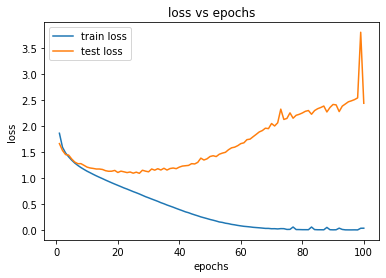

In [ ]:
# plot loss
plt.plot(range(1, len(train_loss) + 1), train_loss, label='train loss')
plt.plot(range(1, len(test_loss) + 1), test_loss, label='test loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss vs epochs')
plt.legend()
plt.show()

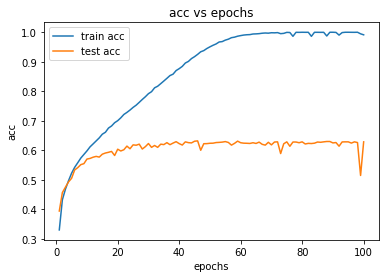

In [ ]:
# plot acc
plt.plot(range(1, NUM_EPOCHS + 1), train_acc, label='train acc')
plt.plot(range(1, NUM_EPOCHS + 1), test_acc, label='test acc')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.title('acc vs epochs')
plt.legend()
plt.show()